# Identifying Particles

Import necessary python libraries

In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
import deeptrack as dt
import keras
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from random import randint 

print("Import Complete")

Import Complete


## Loading in Images
Graph images, verify that the gold-standard center is accurate enough

[[48.5      50.5       0.55125 ]
 [48.5      54.5       0.55125 ]
 [48.5      52.5       0.55125 ]
 ...
 [51.5      52.5       0.077995]
 [51.5      50.5       0.077995]
 [51.5      51.5       0.077995]]
[48.5     50.5      0.55125]


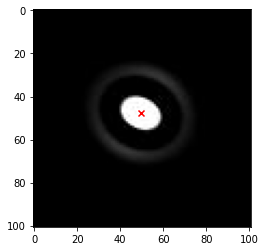

In [3]:
# Load in single image
img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# Convert to DeepTrack 2.0 Feature
img_data = dt.features.Dataset(img_data)
output_image = img_data.resolve()

# Display image
plt.imshow(output_image)

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset)

dataset = dataset / 2.0
print(dataset[:, 0:5])

label = dataset[0]
print(label)

# Plot single image against label position
plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

Finished loading all images
[48.5     50.5      0.55125]


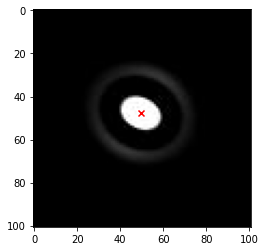

[48.5     50.5      0.55125]


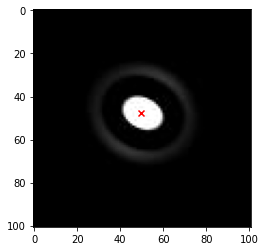

[50.5     50.5      0.63115]


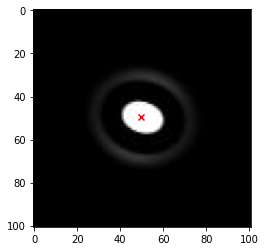

[49.5      52.5       0.077995]


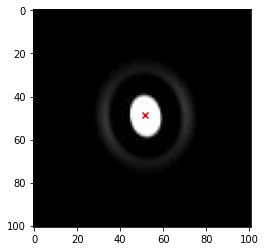

In [4]:
# ==========================================
# Load in all images
NUM_OF_IMAGES = 1000
all_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'image' + str(i + 1) + '.jpg'
#     print("Loading in an image named", image_name)
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
    all_images.append(img_data)

print("Finished loading all images")

img_data = all_images[0]
img_data = dt.features.Dataset(img_data)

output_image = img_data.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.show()

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0

# ==========================================
# Sample a few points to show the true label
chosen = [0, 6, 266, 977]
for i in chosen:
    # Select image plot
    img_data = all_images[i]
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()
    
    # Display image grayscale
    plt.imshow(np.squeeze(output_image), cmap='gray')
    
    # Load in label for selected data
    label = dataset[i]
    print(label)

    # Show image with true label
    plt.imshow(np.squeeze(output_image), cmap='gray')
    plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
    plt.show()
original_all_images = all_images.copy()



(1000, 101, 101)


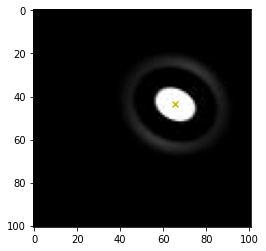

In [5]:
max_width = 101
# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0
new_all_images = [] # 57x57
# random range is 0-44

old_label = []
for i in range(1, 1001):
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')
    # print(img_data)
    C = img_data[22:-22, 22:-22]
# print(C)
    rand_x = randint(0, 44)
    rand_y = randint(0, 44)
    
    D = np.pad(C, ((rand_x, max_width - 57 - rand_x), (rand_y, max_width - 57 - rand_y)), 'constant')
#     print("Old coordinates were ", dataset[0], "Change by", rand_x, rand_y)
    old_label = dataset[0].copy()
    dataset[i - 1] = [dataset[i - 1][0] - 22 + rand_x, dataset[i - 1][1] - 22 + rand_y, dataset[i - 1][2]]
#     print("New coordinates are ", dataset[0])
    
    new_all_images.append(D)
#     plt.imshow(np.squeeze(D), cmap='gray')
#     plt.show()
    
new_all_images = np.array(new_all_images)
print(new_all_images.shape)
# print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1] - 1, label[0] - 1, c="y", marker="x") # 1-indexed, compensate with -1
# plt.scatter(old_label[1] - 1, old_label[0] - 1, c="g", marker="x") # 1-indexed, compensate with -1
plt.show()

In [6]:
# # The generator part
# for i in range(0, len(all_images)):
#     img_data = all_images[i] #all_images[0]
#     label = dataset[i]
#     img_data = dt.features.Dataset(img_data)
#     img_data.properties.setdefault('position', [label[1] - 1, label[0] - 1])
#     # print(img_data.properties)
#     all_images[0] = img_data
# all_images = np.array(all_images)

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [7]:
x_model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    conv_layers_dimensions=(2,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['accuracy'],
    output_activation="linear",
)

print("Model summary:")
x_model.summary()

Model summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 2)       20        
_________________________________________________________________
activation (Activation)      (None, 101, 101, 2)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5202)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                166496    
_________________________________________________________________
activation_1 (Activation)    (None, 32)       

In [8]:
scaling = StandardScaler()
# scaling.fit(original_all_images)
# original_all_images = scaling.transform(original_all_images)

original_all_images = np.array(original_all_images)
all_images = tf.convert_to_tensor(original_all_images)

all_images = tf.convert_to_tensor(new_all_images)

# Labels into individual sets.
x_dataset = np.zeros(1000)
y_dataset = np.zeros(1000)
angle_dataset = np.zeros(1000)

count = 0
for elem in dataset:
    x_dataset[count] = elem[0]
    y_dataset[count] = elem[1]
    count += 1

# x-coordinate position labels
x_dataset = tf.convert_to_tensor(x_dataset)

# all labels
# dataset = tf.convert_to_tensor(dataset)

In [9]:
print("Fitting the model")
history = x_model.fit(
    x=all_images,
    y=x_dataset,
    epochs=2000,
    validation_split=0.4
)

print("Model finished fitting")

Fitting the model
Epoch 1/2000
19/19 [==============================] - 1s 36ms/step - loss: 45.6063 - accuracy: 0.0000e+00 - val_loss: 44.7739 - val_accuracy: 0.0000e+00
Epoch 2/2000
19/19 [==============================] - 1s 30ms/step - loss: 43.2996 - accuracy: 0.0000e+00 - val_loss: 43.0703 - val_accuracy: 0.0000e+00
Epoch 3/2000
19/19 [==============================] - 1s 28ms/step - loss: 41.9034 - accuracy: 0.0000e+00 - val_loss: 41.9643 - val_accuracy: 0.0000e+00
Epoch 4/2000
19/19 [==============================] - 1s 29ms/step - loss: 40.9413 - accuracy: 0.0000e+00 - val_loss: 41.1083 - val_accuracy: 0.0000e+00
Epoch 5/2000
19/19 [==============================] - 1s 32ms/step - loss: 40.1326 - accuracy: 0.0000e+00 - val_loss: 40.3358 - val_accuracy: 0.0000e+00
Epoch 6/2000
19/19 [==============================] - 1s 43ms/step - loss: 39.3826 - accuracy: 0.0000e+00 - val_loss: 39.6038 - val_accuracy: 0.0000e+00
Epoch 7/2000
19/19 [==============================] - 1s 39ms/st

19/19 [==============================] - 1s 31ms/step - loss: 13.9753 - accuracy: 0.0000e+00 - val_loss: 14.6515 - val_accuracy: 0.0000e+00
Epoch 55/2000
19/19 [==============================] - 1s 28ms/step - loss: 13.7785 - accuracy: 0.0000e+00 - val_loss: 14.4682 - val_accuracy: 0.0000e+00
Epoch 56/2000
19/19 [==============================] - 1s 30ms/step - loss: 13.5901 - accuracy: 0.0000e+00 - val_loss: 14.2902 - val_accuracy: 0.0000e+00
Epoch 57/2000
19/19 [==============================] - 1s 29ms/step - loss: 13.4096 - accuracy: 0.0000e+00 - val_loss: 14.1299 - val_accuracy: 0.0000e+00
Epoch 58/2000
19/19 [==============================] - 1s 28ms/step - loss: 13.2429 - accuracy: 0.0000e+00 - val_loss: 13.9753 - val_accuracy: 0.0000e+00
Epoch 59/2000
19/19 [==============================] - 1s 31ms/step - loss: 13.0746 - accuracy: 0.0000e+00 - val_loss: 13.8207 - val_accuracy: 0.0000e+00
Epoch 60/2000
19/19 [==============================] - 1s 27ms/step - loss: 12.9103 - accu

19/19 [==============================] - 1s 30ms/step - loss: 10.8948 - accuracy: 0.0000e+00 - val_loss: 11.6569 - val_accuracy: 0.0000e+00
Epoch 108/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8951 - accuracy: 0.0000e+00 - val_loss: 11.6502 - val_accuracy: 0.0000e+00
Epoch 109/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8924 - accuracy: 0.0000e+00 - val_loss: 11.6484 - val_accuracy: 0.0000e+00
Epoch 110/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8917 - accuracy: 0.0000e+00 - val_loss: 11.6476 - val_accuracy: 0.0000e+00
Epoch 111/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8907 - accuracy: 0.0000e+00 - val_loss: 11.6443 - val_accuracy: 0.0000e+00
Epoch 112/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8910 - accuracy: 0.0000e+00 - val_loss: 11.6376 - val_accuracy: 0.0000e+00
Epoch 113/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8884 

Epoch 160/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 161/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5853 - val_accuracy: 0.0000e+00
Epoch 162/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8728 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 163/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5856 - val_accuracy: 0.0000e+00
Epoch 164/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8742 - accuracy: 0.0000e+00 - val_loss: 11.5828 - val_accuracy: 0.0000e+00
Epoch 165/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 166/2000
19/19 [==============================] - 1s 28ms/step -

Epoch 213/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5873 - val_accuracy: 0.0000e+00
Epoch 214/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5842 - val_accuracy: 0.0000e+00
Epoch 215/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8754 - accuracy: 0.0000e+00 - val_loss: 11.5865 - val_accuracy: 0.0000e+00
Epoch 216/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5827 - val_accuracy: 0.0000e+00
Epoch 217/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8744 - accuracy: 0.0000e+00 - val_loss: 11.5839 - val_accuracy: 0.0000e+00
Epoch 218/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 219/2000
19/19 [==============================] - 1s 28ms/step -

Epoch 266/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5858 - val_accuracy: 0.0000e+00
Epoch 267/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5862 - val_accuracy: 0.0000e+00
Epoch 268/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 269/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 270/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5839 - val_accuracy: 0.0000e+00
Epoch 271/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8748 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 272/2000
19/19 [==============================] - 1s 27ms/step -

Epoch 319/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5854 - val_accuracy: 0.0000e+00
Epoch 320/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5861 - val_accuracy: 0.0000e+00
Epoch 321/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5878 - val_accuracy: 0.0000e+00
Epoch 322/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5832 - val_accuracy: 0.0000e+00
Epoch 323/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8715 - accuracy: 0.0000e+00 - val_loss: 11.5868 - val_accuracy: 0.0000e+00
Epoch 324/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5866 - val_accuracy: 0.0000e+00
Epoch 325/2000
19/19 [==============================] - 1s 29ms/step -

Epoch 372/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8755 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 373/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5869 - val_accuracy: 0.0000e+00
Epoch 374/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8716 - accuracy: 0.0000e+00 - val_loss: 11.5840 - val_accuracy: 0.0000e+00
Epoch 375/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5880 - val_accuracy: 0.0000e+00
Epoch 376/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 377/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5824 - val_accuracy: 0.0000e+00
Epoch 378/2000
19/19 [==============================] - 1s 29ms/step -

Epoch 425/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5851 - val_accuracy: 0.0000e+00
Epoch 426/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8745 - accuracy: 0.0000e+00 - val_loss: 11.5836 - val_accuracy: 0.0000e+00
Epoch 427/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5908 - val_accuracy: 0.0000e+00
Epoch 428/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5844 - val_accuracy: 0.0000e+00
Epoch 429/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8756 - accuracy: 0.0000e+00 - val_loss: 11.5827 - val_accuracy: 0.0000e+00
Epoch 430/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8720 - accuracy: 0.0000e+00 - val_loss: 11.5895 - val_accuracy: 0.0000e+00
Epoch 431/2000
19/19 [==============================] - 1s 29ms/step -

Epoch 478/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5844 - val_accuracy: 0.0000e+00
Epoch 479/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8741 - accuracy: 0.0000e+00 - val_loss: 11.5829 - val_accuracy: 0.0000e+00
Epoch 480/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5851 - val_accuracy: 0.0000e+00
Epoch 481/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5861 - val_accuracy: 0.0000e+00
Epoch 482/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8752 - accuracy: 0.0000e+00 - val_loss: 11.5881 - val_accuracy: 0.0000e+00
Epoch 483/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5866 - val_accuracy: 0.0000e+00
Epoch 484/2000
19/19 [==============================] - 1s 30ms/step -

Epoch 531/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8746 - accuracy: 0.0000e+00 - val_loss: 11.5840 - val_accuracy: 0.0000e+00
Epoch 532/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8741 - accuracy: 0.0000e+00 - val_loss: 11.5896 - val_accuracy: 0.0000e+00
Epoch 533/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5830 - val_accuracy: 0.0000e+00
Epoch 534/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 535/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5885 - val_accuracy: 0.0000e+00
Epoch 536/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8775 - accuracy: 0.0000e+00 - val_loss: 11.5860 - val_accuracy: 0.0000e+00
Epoch 537/2000
19/19 [==============================] - 1s 31ms/step -

Epoch 584/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5856 - val_accuracy: 0.0000e+00
Epoch 585/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8744 - accuracy: 0.0000e+00 - val_loss: 11.5821 - val_accuracy: 0.0000e+00
Epoch 586/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 587/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8751 - accuracy: 0.0000e+00 - val_loss: 11.5930 - val_accuracy: 0.0000e+00
Epoch 588/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8738 - accuracy: 0.0000e+00 - val_loss: 11.5832 - val_accuracy: 0.0000e+00
Epoch 589/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5855 - val_accuracy: 0.0000e+00
Epoch 590/2000
19/19 [==============================] - 1s 28ms/step -

Epoch 637/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5836 - val_accuracy: 0.0000e+00
Epoch 638/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5868 - val_accuracy: 0.0000e+00
Epoch 639/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 640/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5832 - val_accuracy: 0.0000e+00
Epoch 641/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8765 - accuracy: 0.0000e+00 - val_loss: 11.5903 - val_accuracy: 0.0000e+00
Epoch 642/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8717 - accuracy: 0.0000e+00 - val_loss: 11.5831 - val_accuracy: 0.0000e+00
Epoch 643/2000
19/19 [==============================] - 1s 29ms/step -

Epoch 690/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 691/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5847 - val_accuracy: 0.0000e+00
Epoch 692/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8716 - accuracy: 0.0000e+00 - val_loss: 11.5906 - val_accuracy: 0.0000e+00
Epoch 693/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8761 - accuracy: 0.0000e+00 - val_loss: 11.5959 - val_accuracy: 0.0000e+00
Epoch 694/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5842 - val_accuracy: 0.0000e+00
Epoch 695/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 696/2000
19/19 [==============================] - 1s 31ms/step -

Epoch 743/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5849 - val_accuracy: 0.0000e+00
Epoch 744/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5865 - val_accuracy: 0.0000e+00
Epoch 745/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5863 - val_accuracy: 0.0000e+00
Epoch 746/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8745 - accuracy: 0.0000e+00 - val_loss: 11.5873 - val_accuracy: 0.0000e+00
Epoch 747/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5831 - val_accuracy: 0.0000e+00
Epoch 748/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8739 - accuracy: 0.0000e+00 - val_loss: 11.5843 - val_accuracy: 0.0000e+00
Epoch 749/2000
19/19 [==============================] - 1s 28ms/step -

Epoch 796/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5857 - val_accuracy: 0.0000e+00
Epoch 797/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5881 - val_accuracy: 0.0000e+00
Epoch 798/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5846 - val_accuracy: 0.0000e+00
Epoch 799/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 800/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5859 - val_accuracy: 0.0000e+00
Epoch 801/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8728 - accuracy: 0.0000e+00 - val_loss: 11.5869 - val_accuracy: 0.0000e+00
Epoch 802/2000
19/19 [==============================] - 1s 32ms/step -

Epoch 849/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 850/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 851/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8740 - accuracy: 0.0000e+00 - val_loss: 11.5833 - val_accuracy: 0.0000e+00
Epoch 852/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5853 - val_accuracy: 0.0000e+00
Epoch 853/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 854/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8738 - accuracy: 0.0000e+00 - val_loss: 11.5871 - val_accuracy: 0.0000e+00
Epoch 855/2000
19/19 [==============================] - 1s 30ms/step -

Epoch 902/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5860 - val_accuracy: 0.0000e+00
Epoch 903/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 904/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5857 - val_accuracy: 0.0000e+00
Epoch 905/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8718 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 906/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5853 - val_accuracy: 0.0000e+00
Epoch 907/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8721 - accuracy: 0.0000e+00 - val_loss: 11.5889 - val_accuracy: 0.0000e+00
Epoch 908/2000
19/19 [==============================] - 1s 30ms/step -

Epoch 955/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5838 - val_accuracy: 0.0000e+00
Epoch 956/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8741 - accuracy: 0.0000e+00 - val_loss: 11.5847 - val_accuracy: 0.0000e+00
Epoch 957/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 958/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5843 - val_accuracy: 0.0000e+00
Epoch 959/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5867 - val_accuracy: 0.0000e+00
Epoch 960/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5824 - val_accuracy: 0.0000e+00
Epoch 961/2000
19/19 [==============================] - 1s 29ms/step -

Epoch 1008/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8728 - accuracy: 0.0000e+00 - val_loss: 11.5856 - val_accuracy: 0.0000e+00
Epoch 1009/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8742 - accuracy: 0.0000e+00 - val_loss: 11.5891 - val_accuracy: 0.0000e+00
Epoch 1010/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5843 - val_accuracy: 0.0000e+00
Epoch 1011/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5844 - val_accuracy: 0.0000e+00
Epoch 1012/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8717 - accuracy: 0.0000e+00 - val_loss: 11.5870 - val_accuracy: 0.0000e+00
Epoch 1013/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5862 - val_accuracy: 0.0000e+00
Epoch 1014/2000
19/19 [==============================] - 1s 30ms

19/19 [==============================] - 1s 30ms/step - loss: 10.8736 - accuracy: 0.0000e+00 - val_loss: 11.5849 - val_accuracy: 0.0000e+00
Epoch 1061/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 1062/2000
19/19 [==============================] - 1s 35ms/step - loss: 10.8738 - accuracy: 0.0000e+00 - val_loss: 11.5840 - val_accuracy: 0.0000e+00
Epoch 1063/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5865 - val_accuracy: 0.0000e+00
Epoch 1064/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5846 - val_accuracy: 0.0000e+00
Epoch 1065/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8755 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 1066/2000
19/19 [==============================] - 1s 29ms/step - loss: 10

19/19 [==============================] - 1s 30ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5867 - val_accuracy: 0.0000e+00
Epoch 1113/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5858 - val_accuracy: 0.0000e+00
Epoch 1114/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5866 - val_accuracy: 0.0000e+00
Epoch 1115/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5872 - val_accuracy: 0.0000e+00
Epoch 1116/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8762 - accuracy: 0.0000e+00 - val_loss: 11.5926 - val_accuracy: 0.0000e+00
Epoch 1117/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8721 - accuracy: 0.0000e+00 - val_loss: 11.5827 - val_accuracy: 0.0000e+00
Epoch 1118/2000
19/19 [==============================] - 1s 32ms/step - loss: 10

19/19 [==============================] - 1s 29ms/step - loss: 10.8748 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 1165/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5859 - val_accuracy: 0.0000e+00
Epoch 1166/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8720 - accuracy: 0.0000e+00 - val_loss: 11.5846 - val_accuracy: 0.0000e+00
Epoch 1167/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5842 - val_accuracy: 0.0000e+00
Epoch 1168/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8739 - accuracy: 0.0000e+00 - val_loss: 11.5869 - val_accuracy: 0.0000e+00
Epoch 1169/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8741 - accuracy: 0.0000e+00 - val_loss: 11.5843 - val_accuracy: 0.0000e+00
Epoch 1170/2000
19/19 [==============================] - 1s 31ms/step - loss: 10

19/19 [==============================] - 1s 34ms/step - loss: 10.8748 - accuracy: 0.0000e+00 - val_loss: 11.5892 - val_accuracy: 0.0000e+00
Epoch 1217/2000
19/19 [==============================] - 1s 36ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5844 - val_accuracy: 0.0000e+00
Epoch 1218/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8739 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 1219/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8766 - accuracy: 0.0000e+00 - val_loss: 11.5809 - val_accuracy: 0.0000e+00
Epoch 1220/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8756 - accuracy: 0.0000e+00 - val_loss: 11.5849 - val_accuracy: 0.0000e+00
Epoch 1221/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5860 - val_accuracy: 0.0000e+00
Epoch 1222/2000
19/19 [==============================] - 1s 33ms/step - loss: 10

19/19 [==============================] - 1s 39ms/step - loss: 10.8721 - accuracy: 0.0000e+00 - val_loss: 11.5864 - val_accuracy: 0.0000e+00
Epoch 1269/2000
19/19 [==============================] - 1s 38ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5853 - val_accuracy: 0.0000e+00
Epoch 1270/2000
19/19 [==============================] - 1s 34ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5831 - val_accuracy: 0.0000e+00
Epoch 1271/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8753 - accuracy: 0.0000e+00 - val_loss: 11.5801 - val_accuracy: 0.0000e+00
Epoch 1272/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5842 - val_accuracy: 0.0000e+00
Epoch 1273/2000
19/19 [==============================] - 1s 28ms/step - loss: 10.8739 - accuracy: 0.0000e+00 - val_loss: 11.5905 - val_accuracy: 0.0000e+00
Epoch 1274/2000
19/19 [==============================] - 1s 33ms/step - loss: 10

19/19 [==============================] - 1s 32ms/step - loss: 10.8738 - accuracy: 0.0000e+00 - val_loss: 11.5855 - val_accuracy: 0.0000e+00
Epoch 1321/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5883 - val_accuracy: 0.0000e+00
Epoch 1322/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5855 - val_accuracy: 0.0000e+00
Epoch 1323/2000
19/19 [==============================] - 1s 33ms/step - loss: 10.8745 - accuracy: 0.0000e+00 - val_loss: 11.5859 - val_accuracy: 0.0000e+00
Epoch 1324/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 1325/2000
19/19 [==============================] - 1s 33ms/step - loss: 10.8728 - accuracy: 0.0000e+00 - val_loss: 11.5846 - val_accuracy: 0.0000e+00
Epoch 1326/2000
19/19 [==============================] - 1s 29ms/step - loss: 10

19/19 [==============================] - 1s 39ms/step - loss: 10.8741 - accuracy: 0.0000e+00 - val_loss: 11.5825 - val_accuracy: 0.0000e+00
Epoch 1373/2000
19/19 [==============================] - 1s 41ms/step - loss: 10.8760 - accuracy: 0.0000e+00 - val_loss: 11.5865 - val_accuracy: 0.0000e+00
Epoch 1374/2000
19/19 [==============================] - 1s 34ms/step - loss: 10.8748 - accuracy: 0.0000e+00 - val_loss: 11.5855 - val_accuracy: 0.0000e+00
Epoch 1375/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8721 - accuracy: 0.0000e+00 - val_loss: 11.5843 - val_accuracy: 0.0000e+00
Epoch 1376/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5882 - val_accuracy: 0.0000e+00
Epoch 1377/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5857 - val_accuracy: 0.0000e+00
Epoch 1378/2000
19/19 [==============================] - 1s 32ms/step - loss: 10

19/19 [==============================] - 1s 30ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 1425/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8728 - accuracy: 0.0000e+00 - val_loss: 11.5878 - val_accuracy: 0.0000e+00
Epoch 1426/2000
19/19 [==============================] - 1s 34ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5842 - val_accuracy: 0.0000e+00
Epoch 1427/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5832 - val_accuracy: 0.0000e+00
Epoch 1428/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8772 - accuracy: 0.0000e+00 - val_loss: 11.5883 - val_accuracy: 0.0000e+00
Epoch 1429/2000
19/19 [==============================] - 1s 36ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5839 - val_accuracy: 0.0000e+00
Epoch 1430/2000
19/19 [==============================] - 1s 43ms/step - loss: 10

19/19 [==============================] - 1s 31ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 1477/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5895 - val_accuracy: 0.0000e+00
Epoch 1478/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8736 - accuracy: 0.0000e+00 - val_loss: 11.5838 - val_accuracy: 0.0000e+00
Epoch 1479/2000
19/19 [==============================] - 1s 36ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5833 - val_accuracy: 0.0000e+00
Epoch 1480/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5844 - val_accuracy: 0.0000e+00
Epoch 1481/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5871 - val_accuracy: 0.0000e+00
Epoch 1482/2000
19/19 [==============================] - 1s 30ms/step - loss: 10

19/19 [==============================] - 1s 51ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5851 - val_accuracy: 0.0000e+00
Epoch 1529/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8777 - accuracy: 0.0000e+00 - val_loss: 11.5817 - val_accuracy: 0.0000e+00
Epoch 1530/2000
19/19 [==============================] - 1s 44ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5920 - val_accuracy: 0.0000e+00
Epoch 1531/2000
19/19 [==============================] - 1s 38ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5854 - val_accuracy: 0.0000e+00
Epoch 1532/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8764 - accuracy: 0.0000e+00 - val_loss: 11.5812 - val_accuracy: 0.0000e+00
Epoch 1533/2000
19/19 [==============================] - 1s 38ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5870 - val_accuracy: 0.0000e+00
Epoch 1534/2000
19/19 [==============================] - 1s 75ms/step - loss: 10

19/19 [==============================] - 1s 27ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5833 - val_accuracy: 0.0000e+00
Epoch 1581/2000
19/19 [==============================] - 0s 26ms/step - loss: 10.8738 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 1582/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8740 - accuracy: 0.0000e+00 - val_loss: 11.5826 - val_accuracy: 0.0000e+00
Epoch 1583/2000
19/19 [==============================] - 0s 25ms/step - loss: 10.8740 - accuracy: 0.0000e+00 - val_loss: 11.5903 - val_accuracy: 0.0000e+00
Epoch 1584/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8747 - accuracy: 0.0000e+00 - val_loss: 11.5852 - val_accuracy: 0.0000e+00
Epoch 1585/2000
19/19 [==============================] - 0s 26ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5889 - val_accuracy: 0.0000e+00
Epoch 1586/2000
19/19 [==============================] - 1s 27ms/step - loss: 10

19/19 [==============================] - 1s 28ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5869 - val_accuracy: 0.0000e+00
Epoch 1633/2000
19/19 [==============================] - 0s 26ms/step - loss: 10.8729 - accuracy: 0.0000e+00 - val_loss: 11.5851 - val_accuracy: 0.0000e+00
Epoch 1634/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5835 - val_accuracy: 0.0000e+00
Epoch 1635/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5889 - val_accuracy: 0.0000e+00
Epoch 1636/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5841 - val_accuracy: 0.0000e+00
Epoch 1637/2000
19/19 [==============================] - 1s 27ms/step - loss: 10.8740 - accuracy: 0.0000e+00 - val_loss: 11.5841 - val_accuracy: 0.0000e+00
Epoch 1638/2000
19/19 [==============================] - 1s 27ms/step - loss: 10

19/19 [==============================] - 1s 47ms/step - loss: 10.8767 - accuracy: 0.0000e+00 - val_loss: 11.5821 - val_accuracy: 0.0000e+00
Epoch 1685/2000
19/19 [==============================] - 1s 47ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5872 - val_accuracy: 0.0000e+00
Epoch 1686/2000
19/19 [==============================] - 1s 47ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 1687/2000
19/19 [==============================] - 1s 47ms/step - loss: 10.8722 - accuracy: 0.0000e+00 - val_loss: 11.5865 - val_accuracy: 0.0000e+00
Epoch 1688/2000
19/19 [==============================] - 1s 47ms/step - loss: 10.8738 - accuracy: 0.0000e+00 - val_loss: 11.5864 - val_accuracy: 0.0000e+00
Epoch 1689/2000
19/19 [==============================] - 1s 47ms/step - loss: 10.8770 - accuracy: 0.0000e+00 - val_loss: 11.5807 - val_accuracy: 0.0000e+00
Epoch 1690/2000
19/19 [==============================] - 1s 49ms/step - loss: 10

19/19 [==============================] - 1s 47ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5855 - val_accuracy: 0.0000e+00
Epoch 1737/2000
19/19 [==============================] - 1s 33ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5863 - val_accuracy: 0.0000e+00
Epoch 1738/2000
19/19 [==============================] - 1s 33ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5858 - val_accuracy: 0.0000e+00
Epoch 1739/2000
19/19 [==============================] - 1s 43ms/step - loss: 10.8743 - accuracy: 0.0000e+00 - val_loss: 11.5848 - val_accuracy: 0.0000e+00
Epoch 1740/2000
19/19 [==============================] - 1s 43ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5850 - val_accuracy: 0.0000e+00
Epoch 1741/2000
19/19 [==============================] - 1s 35ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5849 - val_accuracy: 0.0000e+00
Epoch 1742/2000
19/19 [==============================] - 1s 31ms/step - loss: 10

19/19 [==============================] - 1s 38ms/step - loss: 10.8735 - accuracy: 0.0000e+00 - val_loss: 11.5847 - val_accuracy: 0.0000e+00
Epoch 1789/2000
19/19 [==============================] - 1s 41ms/step - loss: 10.8730 - accuracy: 0.0000e+00 - val_loss: 11.5880 - val_accuracy: 0.0000e+00
Epoch 1790/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8720 - accuracy: 0.0000e+00 - val_loss: 11.5840 - val_accuracy: 0.0000e+00
Epoch 1791/2000
19/19 [==============================] - 1s 35ms/step - loss: 10.8752 - accuracy: 0.0000e+00 - val_loss: 11.5805 - val_accuracy: 0.0000e+00
Epoch 1792/2000
19/19 [==============================] - 1s 33ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5869 - val_accuracy: 0.0000e+00
Epoch 1793/2000
19/19 [==============================] - 1s 41ms/step - loss: 10.8745 - accuracy: 0.0000e+00 - val_loss: 11.5884 - val_accuracy: 0.0000e+00
Epoch 1794/2000
19/19 [==============================] - 1s 38ms/step - loss: 10

19/19 [==============================] - 1s 33ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5861 - val_accuracy: 0.0000e+00
Epoch 1841/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5879 - val_accuracy: 0.0000e+00
Epoch 1842/2000
19/19 [==============================] - 1s 37ms/step - loss: 10.8727 - accuracy: 0.0000e+00 - val_loss: 11.5832 - val_accuracy: 0.0000e+00
Epoch 1843/2000
19/19 [==============================] - 1s 39ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5858 - val_accuracy: 0.0000e+00
Epoch 1844/2000
19/19 [==============================] - 1s 52ms/step - loss: 10.8726 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 1845/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5858 - val_accuracy: 0.0000e+00
Epoch 1846/2000
19/19 [==============================] - 1s 33ms/step - loss: 10

19/19 [==============================] - 1s 35ms/step - loss: 10.8734 - accuracy: 0.0000e+00 - val_loss: 11.5853 - val_accuracy: 0.0000e+00
Epoch 1893/2000
19/19 [==============================] - 1s 38ms/step - loss: 10.8749 - accuracy: 0.0000e+00 - val_loss: 11.5830 - val_accuracy: 0.0000e+00
Epoch 1894/2000
19/19 [==============================] - 1s 43ms/step - loss: 10.8723 - accuracy: 0.0000e+00 - val_loss: 11.5861 - val_accuracy: 0.0000e+00
Epoch 1895/2000
19/19 [==============================] - 1s 34ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5866 - val_accuracy: 0.0000e+00
Epoch 1896/2000
19/19 [==============================] - 1s 32ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5814 - val_accuracy: 0.0000e+00
Epoch 1897/2000
19/19 [==============================] - 1s 36ms/step - loss: 10.8725 - accuracy: 0.0000e+00 - val_loss: 11.5859 - val_accuracy: 0.0000e+00
Epoch 1898/2000
19/19 [==============================] - 1s 35ms/step - loss: 10

19/19 [==============================] - 1s 34ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5842 - val_accuracy: 0.0000e+00
Epoch 1945/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8746 - accuracy: 0.0000e+00 - val_loss: 11.5883 - val_accuracy: 0.0000e+00
Epoch 1946/2000
19/19 [==============================] - 1s 36ms/step - loss: 10.8737 - accuracy: 0.0000e+00 - val_loss: 11.5822 - val_accuracy: 0.0000e+00
Epoch 1947/2000
19/19 [==============================] - 1s 30ms/step - loss: 10.8732 - accuracy: 0.0000e+00 - val_loss: 11.5859 - val_accuracy: 0.0000e+00
Epoch 1948/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8724 - accuracy: 0.0000e+00 - val_loss: 11.5856 - val_accuracy: 0.0000e+00
Epoch 1949/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8720 - accuracy: 0.0000e+00 - val_loss: 11.5849 - val_accuracy: 0.0000e+00
Epoch 1950/2000
19/19 [==============================] - 1s 28ms/step - loss: 10

19/19 [==============================] - 1s 38ms/step - loss: 10.8733 - accuracy: 0.0000e+00 - val_loss: 11.5854 - val_accuracy: 0.0000e+00
Epoch 1997/2000
19/19 [==============================] - 1s 33ms/step - loss: 10.8742 - accuracy: 0.0000e+00 - val_loss: 11.5837 - val_accuracy: 0.0000e+00
Epoch 1998/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8731 - accuracy: 0.0000e+00 - val_loss: 11.5845 - val_accuracy: 0.0000e+00
Epoch 1999/2000
19/19 [==============================] - 1s 29ms/step - loss: 10.8736 - accuracy: 0.0000e+00 - val_loss: 11.5863 - val_accuracy: 0.0000e+00
Epoch 2000/2000
19/19 [==============================] - 1s 31ms/step - loss: 10.8728 - accuracy: 0.0000e+00 - val_loss: 11.5846 - val_accuracy: 0.0000e+00
Model finished fitting


In [ ]:
x_predicted = np.array(x_model.predict_on_batch(all_images))
# print(x_predicted)
# print(x_dataset)

count = 0
for i in range(0, 1000):
    difference = round(round(x_predicted[i][0], 1) - float(x_dataset[i]), 2)
    if abs(difference) <= 1.0:
        count += 1
    else:
        print(difference, "(", round(x_predicted[i][0], 1), ",", float(x_dataset[i]), ")")


print("Number of correct are", count)

# 357 correct within 0.5
# 613 correct within 1.0

In [11]:
print(set(np.array(x_dataset)))

{26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5}


Final loss: 10.873
Final accuracy: 0.0
Final val_loss: 11.585
Final val_accuracy: 0.0


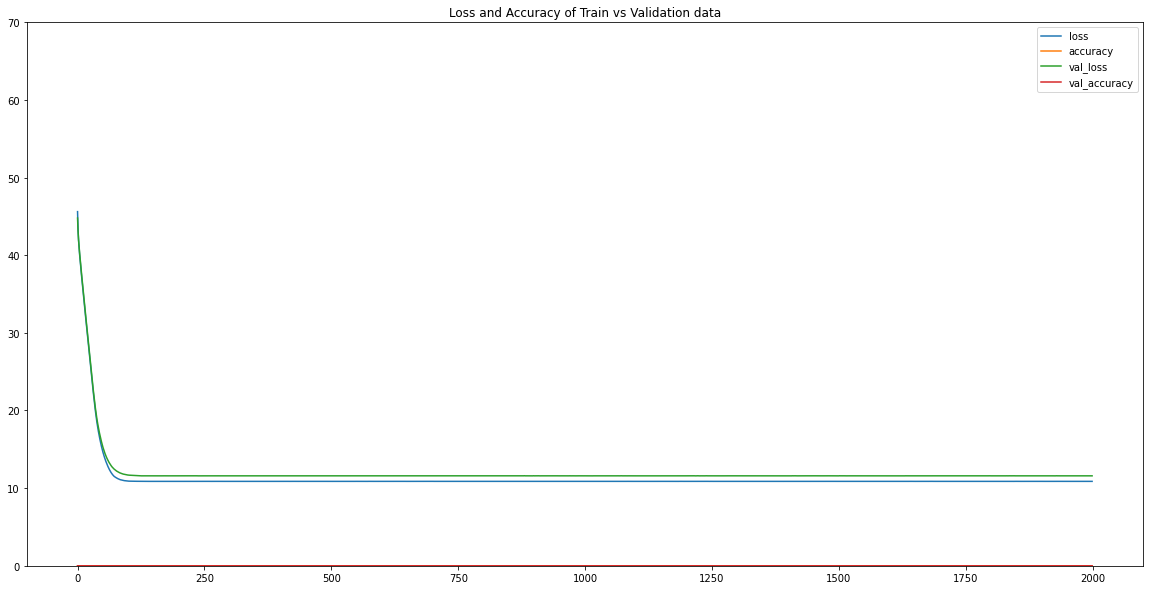

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [12]:
def plot_history(history, ylim=70): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep
plot_history(history)

In [13]:
# y_model = dt.models.convolutional(
#     input_shape=(101, 101, 1), 
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_absolute_error', 'accuracy']
# )

# print("Model summary:")
# y_model.summary()

# print("Fitting the model")
# history = y_model.fit(
#     x=all_images,
#     y=y_dataset,
#     epochs=30,
#     validation_split=0.4
# )

# print("Model finished fitting")

In [14]:
# [[61.498257]
#  [40.661373]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [34.33226 ]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [32.626095]
#  [32.645126]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [40.66136 ]
#  [40.79866 ]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.49822 ]
#  [46.024326]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [45.823006]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [34.33226 ]
#  [32.626095]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [34.33226 ]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [34.33226 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [40.661335]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66193 ]
#  [61.498257]
#  [61.498257]
#  [46.341908]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [34.33226 ]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [40.66136 ]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [34.33226 ]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.495907]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498234]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [34.33226 ]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [34.33214 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.661366]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498253]
#  [32.626095]]
# tf.Tensor(
# [57.5 39.5 68.5 53.5 53.5 48.5 34.5 57.5 64.5 43.5 51.5 71.5 27.5 51.5
#  46.5 57.5 57.5 37.5 47.5 51.5 55.5 49.5 39.5 42.5 58.5 31.5 32.5 71.5
#  37.5 70.5 68.5 26.5 68.5 51.5 54.5 45.5 47.5 58.5 32.5 41.5 30.5 49.5
#  37.5 41.5 29.5 54.5 31.5 67.5 49.5 48.5 41.5 60.5 53.5 29.5 29.5 65.5
#  62.5 55.5 43.5 41.5 66.5 49.5 45.5 33.5 47.5 60.5 54.5 61.5 67.5 69.5
#  70.5 49.5 70.5 53.5 67.5 44.5 37.5 35.5 36.5 59.5 33.5 32.5 53.5 67.5
#  72.5 50.5 41.5 44.5 38.5 53.5 50.5 39.5 71.5 30.5 35.5 45.5 51.5 60.5
#  39.5 29.5 40.5 39.5 35.5 44.5 47.5 46.5 50.5 68.5 39.5 63.5 43.5 31.5
#  50.5 43.5 49.5 70.5 46.5 41.5 40.5 70.5 45.5 68.5 33.5 38.5 41.5 36.5
#  31.5 45.5 40.5 69.5 60.5 32.5 63.5 29.5 61.5 46.5 69.5 30.5 34.5 46.5
#  67.5 61.5 61.5 62.5 55.5 51.5 46.5 36.5 53.5 53.5 53.5 45.5 50.5 28.5
#  67.5 45.5 36.5 56.5 60.5 59.5 42.5 30.5 29.5 46.5 34.5 48.5 41.5 54.5
#  48.5 56.5 26.5 33.5 50.5 50.5 28.5 29.5 32.5 45.5 48.5 70.5 40.5 43.5
#  71.5 30.5 71.5 67.5 73.5 51.5 56.5 62.5 59.5 28.5 70.5 45.5 52.5 57.5
#  29.5 30.5 42.5 68.5 41.5 36.5 58.5 29.5 61.5 60.5 27.5 41.5 47.5 42.5
#  60.5 46.5 50.5 52.5 56.5 27.5 57.5 45.5 39.5 35.5 67.5 48.5 63.5 47.5
#  51.5 57.5 65.5 39.5 64.5 41.5 69.5 43.5 52.5 45.5 43.5 26.5 34.5 64.5
#  36.5 67.5 42.5 59.5 60.5 59.5 32.5 65.5 59.5 30.5 40.5 41.5 59.5 47.5
#  57.5 51.5 33.5 56.5 70.5 51.5 35.5 61.5 72.5 56.5 44.5 45.5 28.5 40.5
#  67.5 62.5 69.5 54.5 28.5 57.5 59.5 63.5 49.5 32.5 40.5 35.5 33.5 37.5
#  66.5 42.5 46.5 29.5 49.5 38.5 64.5 56.5 35.5 61.5 43.5 38.5 72.5 29.5
#  46.5 58.5 63.5 28.5 61.5 63.5 54.5 63.5 58.5 41.5 47.5 44.5 45.5 46.5
#  69.5 57.5 39.5 65.5 32.5 47.5 36.5 33.5 70.5 60.5 64.5 68.5 48.5 57.5
#  56.5 57.5 56.5 47.5 67.5 72.5 30.5 69.5 65.5 68.5 48.5 31.5 62.5 28.5
#  27.5 31.5 32.5 64.5 67.5 64.5 32.5 30.5 39.5 62.5 42.5 63.5 47.5 54.5
#  49.5 71.5 30.5 36.5 72.5 53.5 61.5 58.5 55.5 68.5 63.5 28.5 43.5 63.5
#  58.5 42.5 44.5 59.5 62.5 30.5 66.5 46.5 68.5 60.5 39.5 60.5 36.5 35.5
#  42.5 44.5 52.5 58.5 42.5 46.5 36.5 70.5 36.5 58.5 71.5 30.5 45.5 45.5
#  45.5 40.5 34.5 69.5 65.5 47.5 48.5 46.5 32.5 60.5 52.5 41.5 34.5 27.5
#  67.5 60.5 26.5 64.5 41.5 31.5 40.5 38.5 34.5 39.5 68.5 67.5 52.5 38.5
#  29.5 32.5 69.5 36.5 42.5 33.5 58.5 61.5 51.5 46.5 52.5 51.5 61.5 56.5
#  59.5 34.5 69.5 41.5 61.5 38.5 39.5 59.5 43.5 31.5 70.5 41.5 47.5 72.5
#  52.5 51.5 46.5 58.5 65.5 38.5 61.5 49.5 37.5 29.5 59.5 51.5 28.5 51.5
#  58.5 39.5 58.5 41.5 69.5 36.5 56.5 50.5 37.5 38.5 42.5 67.5 57.5 30.5
#  58.5 45.5 60.5 35.5 44.5 40.5 53.5 31.5 37.5 55.5 36.5 36.5 72.5 59.5
#  68.5 39.5 38.5 40.5 64.5 62.5 42.5 47.5 43.5 59.5 34.5 69.5 31.5 67.5
#  35.5 41.5 32.5 56.5 56.5 39.5 34.5 37.5 44.5 28.5 66.5 56.5 63.5 37.5
#  57.5 69.5 68.5 52.5 63.5 32.5 39.5 66.5 56.5 65.5 50.5 50.5 39.5 71.5
#  60.5 30.5 64.5 32.5 68.5 52.5 59.5 55.5 55.5 63.5 52.5 36.5 48.5 67.5
#  29.5 38.5 40.5 37.5 55.5 52.5 41.5 73.5 50.5 72.5 71.5 61.5 40.5 29.5
#  53.5 70.5 67.5 31.5 62.5 45.5 29.5 56.5 69.5 59.5 31.5 40.5 43.5 58.5
#  47.5 36.5 52.5 37.5 68.5 49.5 42.5 71.5 54.5 47.5 60.5 43.5 40.5 46.5
#  51.5 42.5 71.5 62.5 57.5 38.5 43.5 45.5 67.5 42.5 63.5 60.5 33.5 63.5
#  42.5 34.5 55.5 68.5 31.5 43.5 56.5 45.5 43.5 59.5 51.5 62.5 30.5 55.5
#  35.5 29.5 63.5 33.5 37.5 70.5 57.5 69.5 44.5 39.5 48.5 40.5 42.5 55.5
#  32.5 62.5 70.5 39.5 53.5 68.5 33.5 31.5 29.5 37.5 54.5 63.5 61.5 64.5
#  63.5 35.5 50.5 68.5 71.5 53.5 72.5 46.5 60.5 66.5 53.5 56.5 51.5 70.5
#  67.5 47.5 38.5 47.5 72.5 64.5 48.5 49.5 72.5 34.5 47.5 32.5 61.5 67.5
#  56.5 39.5 68.5 56.5 55.5 33.5 70.5 27.5 36.5 59.5 68.5 30.5 33.5 31.5
#  44.5 51.5 68.5 55.5 63.5 73.5 32.5 70.5 33.5 50.5 37.5 35.5 45.5 72.5
#  33.5 65.5 32.5 55.5 43.5 54.5 42.5 67.5 48.5 64.5 37.5 68.5 52.5 67.5
#  40.5 71.5 53.5 52.5 64.5 51.5 51.5 64.5 58.5 49.5 50.5 70.5 52.5 31.5
#  27.5 27.5 52.5 57.5 55.5 41.5 68.5 45.5 31.5 52.5 27.5 67.5 51.5 51.5
#  48.5 61.5 59.5 63.5 72.5 59.5 29.5 50.5 35.5 35.5 65.5 29.5 65.5 60.5
#  30.5 36.5 32.5 37.5 54.5 69.5 58.5 53.5 49.5 72.5 52.5 45.5 38.5 42.5
#  37.5 39.5 42.5 66.5 67.5 68.5 30.5 49.5 34.5 66.5 48.5 41.5 52.5 40.5
#  30.5 32.5 68.5 59.5 52.5 52.5 61.5 66.5 45.5 45.5 62.5 30.5 69.5 43.5
#  37.5 37.5 51.5 28.5 31.5 30.5 62.5 31.5 40.5 54.5 66.5 37.5 65.5 69.5
#  65.5 71.5 42.5 57.5 57.5 34.5 37.5 63.5 67.5 28.5 71.5 43.5 52.5 70.5
#  44.5 47.5 39.5 59.5 49.5 44.5 36.5 30.5 35.5 27.5 45.5 35.5 46.5 37.5
#  35.5 47.5 50.5 60.5 48.5 65.5 34.5 52.5 38.5 41.5 63.5 62.5 65.5 71.5
#  49.5 28.5 65.5 31.5 49.5 63.5 44.5 37.5 58.5 53.5 67.5 44.5 70.5 57.5
#  34.5 69.5 67.5 46.5 52.5 38.5 52.5 55.5 29.5 59.5 49.5 42.5 37.5 51.5
#  45.5 41.5 66.5 49.5 31.5 43.5 33.5 29.5 45.5 57.5 33.5 65.5 66.5 64.5
#  51.5 30.5 49.5 57.5 38.5 52.5 54.5 47.5 55.5 45.5 62.5 35.5 52.5 65.5
#  53.5 35.5 40.5 55.5 33.5 40.5 58.5 68.5 33.5 35.5 52.5 54.5 52.5 31.5
#  54.5 68.5 40.5 49.5 33.5 56.5 42.5 31.5 68.5 51.5 39.5 28.5 49.5 59.5
#  67.5 53.5 42.5 66.5 73.5 60.5 37.5 67.5 55.5 55.5 50.5 56.5 44.5 55.5
#  60.5 49.5 38.5 30.5 59.5 54.5 46.5 48.5 36.5 71.5 64.5 40.5 49.5 38.5
#  40.5 45.5 58.5 42.5 70.5 53.5 32.5 52.5 65.5 33.5 66.5 66.5 59.5 45.5
#  31.5 34.5 50.5 31.5 71.5 71.5 68.5 58.5 57.5 44.5 36.5 38.5 43.5 33.5
#  40.5 36.5 55.5 49.5 62.5 30.5], shape=(1000,), dtype=float64)

In [15]:
# y_predicted = y_model.predict_on_batch(all_images)
# print(y_predicted)
# print(y_dataset)